In [25]:
import numpy as np
from pettingzoo.classic.chess import chess, chess_utils
import torch as T
import torch.optim as optim
import torch.nn as nn
import chess as c
import reward_utils
import matplotlib.pyplot as plt

In [26]:
# Constants
STATE_DIM = 8*8*111
ACTION_DIM = 8*8*73 #These vals pulled from PettingZoo documentation

P1 = 'player_0'
P2 = 'player_1'

FLEX_WEIGHT = 0.25
MATERIAL_WEIGHT = 0.5
KING_SAFETY_WEIGHT = 0.25
BASE_MOVE_PENALTY = 0.001
DRAW_BASE = 0.01

# DECISIVE_STATE_MULTIPLIER = 20

In [27]:
class ReplayBuffer():
    def __init__(self, observation_dim: int, size: int, batch_size: int = 32) -> None:
        # Initializing buffers
        self.obs_buf = np.zeros([size, observation_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.int16)
        self.rews_buf = np.zeros([size], dtype=np.float16)
        self.next_obs_buf = np.zeros([size, observation_dim], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=bool)
        # Defining attributes and the pointer
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    # Store incoming SARS(no second A) data in the buffers
    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs.flatten()
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.next_obs_buf[self.ptr] = next_obs.flatten()
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    
    # Sample from the buffers
    def sample_batch(self) -> dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

In [28]:
# Architecture for the Deep Q Network
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super(Network, self).__init__()

        # Adjust only after fixing everything that could possibly be a bug
        self.layers = nn.Sequential(  
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 256), 
            nn.ReLU(), 
            nn.Linear(256, out_dim)
        )

    def forward(self, x: T.Tensor) -> T.Tensor:
        return self.layers(x)

In [29]:
class QAgent():
    def __init__(self, 
                 env: chess.raw_env, 
                 agent: str,
                 buffer_size: int,
                 batch_size: int,
                 device: T.device) -> None:
        # This id is to comply with PettingZoo's indexing
        self.id = "player_0" if agent == P1 else "player_1"
        obs_dict = env.observe(agent)
        self.observation_space = obs_dict["observation"]
        self.action_mask = obs_dict['action_mask']
        self.action_space = env.action_space(agent)
        self.replay_buffer = ReplayBuffer(STATE_DIM, buffer_size, batch_size)
        self.dqn = Network(STATE_DIM, ACTION_DIM).to(device)
        self.dqn_target = Network(STATE_DIM, ACTION_DIM).to(device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        self.optimizer = optim.Adam(self.dqn.parameters())

        # Params for recording training progress
        self.loss_over_time = []
        self.scores_over_time = []
        self.score = 0

In [30]:
# Necessary Utility Fuctions (Possibly WIP?)
def move_list_to_pgn(move_list: list[str]):
    pgn_str = ""
    for ind, move in enumerate(move_list):
        if (ind % 2 == 0):
            pgn_str += f"{(ind // 2) + 1}.{move} "
        else:
            pgn_str += f"{move} "
    
    return pgn_str

In [31]:
class MultiAgentDeepQ_Chess():
    def __init__(self, 
                 buffer_size: int,
                 batch_size: int,
                 iters_between_network_copies: int,
                 epsilon_decay: float,
                 learning_rate: float = 0.001,
                 max_epsilon: float = 1.0,
                 min_epsilon: float = 0.1,
                 gamma: float = 0.99,
                 ):
        
        self.env = chess.raw_env()
        self.last_board = None
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        self.epsilon = max_epsilon
        self.max_epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        self.target_update_count = iters_between_network_copies
        self.gamma = gamma
        self.device = T.device(
            "cuda" if T.cuda.is_available() else "cpu"
        )
        self.w_agent = QAgent(self.env, 
                              P1, 
                              buffer_size, 
                              batch_size, 
                              self.device)
        self.b_agent = QAgent(self.env, 
                              P2, 
                              buffer_size, 
                              batch_size, 
                              self.device)
        
        # White goes first
        self.cur_agent = self.w_agent
        self.next_agent = self.b_agent
        self.current_transition = []
        self.move_list = []
        self.is_test = False
    
    def select_action(self, agent: QAgent):
        state = agent.observation_space.flatten()
        # Epsilon greedy impl
        if self.epsilon > np.random.random():
            action = agent.action_space.sample(agent.action_mask)
        else:
            state_tensor = T.FloatTensor(state).to(self.device)
            if (self.env.board.turn == c.WHITE and agent.id == 'player_1') or (self.env.board.turn == c.BLACK and agent.id == 'player_0'):
                    print("WARNING, BOARD'S ACTIVE AGENT AND MODEL'S ACTIVE AGENT ARE DIFFERENT!")
            q_values = agent.dqn(state_tensor)
            # Apply action mask
            q_values[agent.action_mask == 0] = -1e9
            # print("num actions in this position according to network: ", agent.action_mask.sum())
            # print("Actual number of moves is ", self.env.board.legal_moves.count())
            action = q_values.argmax().item()
        
        # Adding state and action to current transition if training
        if not self.is_test:
            self.current_transition = [state, action]
        
        return action

    def step(self, action):
        # Update last board, then make the chosen move on the real board
        self.last_board = self.env.board.copy()
        self.env.step(action)
        move = self.env.board.peek()
        # Append to movelist
        self.move_list.append(self.last_board.san(move))

        # Updating old agent's observation space post-move
        self.cur_agent.observation_space = self.env.observe(self.cur_agent.id)['observation']


        reward, terminated, truncated = self.env.rewards[self.cur_agent.id], self.env.terminations[self.cur_agent.id], self.env.truncations[self.cur_agent.id]
        done = terminated or truncated

        # reward = self.calculate_reward(
        #     True if self.cur_agent.id == P1 else False
        # )

        if not self.is_test:
            self.current_transition += [reward, self.cur_agent.observation_space, done]
            self.cur_agent.replay_buffer.store(*self.current_transition)
            self.current_transition = []
        
        # Finally, switch agents since we took a step
        self.cur_agent, self.next_agent = self.next_agent, self.cur_agent

        return reward, done
    
    def update_model(self, agent: QAgent):
        samples = agent.replay_buffer.sample_batch()
        loss = self._compute_dqn_loss(samples, agent)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step()

        return loss.item()
    
    def _compute_dqn_loss(self, samples: dict[str, np.ndarray], agent: QAgent) -> T.Tensor:
        device = self.device # Just to shorten following lines
        # We know these samples will be ndarrays, so we need to first get them
        # to be tensors
        state = T.from_numpy(samples["obs"]).to(device)
        next_state = T.from_numpy(samples["next_obs"]).to(device)
        action = T.from_numpy(samples["acts"].reshape(-1, 1)).to(device)
        reward = T.from_numpy(samples["rews"].reshape(-1, 1)).to(device)
        done = T.from_numpy(samples["done"].reshape(-1, 1)).to(device)

        # Perform the DQN update using action mask
        curr_q_vals = agent.dqn.forward(state)
        curr_q_vals = curr_q_vals * T.from_numpy(agent.action_mask).to(device)
        curr_q_vals = curr_q_vals.gather(1, action.long())

        next_q_vals = agent.dqn_target.forward(next_state)
        next_q_vals = next_q_vals * T.from_numpy(agent.action_mask).to(device)
        next_q_vals = next_q_vals.max(dim=1, keepdim=True)[0]

        mask = ~done # We don't want to try to calculate future returns of a terminal state
        # Q Update rule, new_Q = old_Q + lr * (reward + (discount_factor * estimated_future_returns - current_returns))
        target = (curr_q_vals + self.learning_rate * (reward + (self.gamma * next_q_vals - curr_q_vals) * mask)).to(device)
        loss = nn.functional.smooth_l1_loss(curr_q_vals, target)
        return loss
    
    # def calculate_reward(self, evaluatingWhite: bool) -> float:
    #     # board.turn is True when it is White's turn, and false when Black's
    #     game_status = self.env.board.result()
    #     if (evaluatingWhite and game_status == '0-1') or (not evaluatingWhite and game_status == '1-0'): # Agent was checkmated
    #         # We're gonna normalize the position evaluation heuristics so this is 2x the max value for that
    #         return -50.0 
    #     elif game_status == '1/2-1/2' or self.env.board.can_claim_draw(): #Draw
    #         # Check the ply before the draw for the material imbalance--we want to reward draws found while down material
    #         # while punishing draws while up material
    #         # Will be positive if white has more material, else negative
    #         mat_difference = reward_utils.get_net_material(self.last_board)
    #         #Drew with more material, negative reward scaled w how much material
    #         if (evaluatingWhite and mat_difference < 0) or (not evaluatingWhite and mat_difference > 0):
    #             return -1 * abs(mat_difference) * DRAW_BASE
    #         # Drew with less material, positive reward scaled with the material difference
    #         elif (evaluatingWhite and mat_difference > 0) or (not evaluatingWhite and mat_difference < 0):
    #             return abs(mat_difference) * DRAW_BASE
    #     elif (evaluatingWhite and game_status == '1-0') or (not evaluatingWhite and game_status == '0-1'): # Agent delivered checkmate on the previous move
    #         return 50.0
    #     # In case where no result has been achieved, use heuristics
    #     flex_score = reward_utils.opponent_flex_penalty(self.env.board)
    #     material_score = reward_utils.material_reward(self.env.board)
    #     if not evaluatingWhite: # Negate value if eval'ing Black so we're not feeding negative into reward val
    #         material_score *= -1
    #     low_movecount_bonus = 1 if self.env.board.ply() < 200 else 0
    #     return (flex_score + material_score + low_movecount_bonus) / 2
    
    def train(self, num_games: int, cmd_line_update_interval: int = 100, epsilon_reset_interval: int = 20000):
        self.is_test = False
        update_count = 0
        epsilon_over_time = []
        cur_batch_size = 0

        # Training loop
        for game in range(1, num_games+1):
            # Epsilon reset check:
            if game % epsilon_reset_interval == 0 and self.epsilon <= self.min_epsilon:
                self.epsilon = self.max_epsilon
            
            # Setting up the training environment...
            self.env.reset()
            done = False
            self.cur_agent, self.next_agent = self.w_agent, self.b_agent
            initial_state = self.env.observe(self.cur_agent.id)
            self.cur_agent.observation_space = initial_state["observation"]
            self.cur_agent.action_mask = initial_state["action_mask"]
            while not done:
                action = self.select_action(self.cur_agent)
                #print("Agent selected the move ", move)
                reward, done = self.step(action)
                # Update the new cur_agent's observation space and action mask after the move
                # Note--this is why we don't directly return a new state in the step fn:
                # We need to update the agents anyway since they're the ones that store
                # the observation space and action mask
                new_state = self.env.observe(self.cur_agent.id)
                self.cur_agent.observation_space = new_state["observation"]
                self.cur_agent.action_mask = new_state["action_mask"]
                cur_batch_size += 1 # We saved the transition (ie move) to the replay buffer
                self.cur_agent.score += reward

                if done:
                    # A result was reached after the move was executed
                    # We check the opponent's reward for their reward (ie if they were checkmated or not)
                    # opp_reward = self.calculate_reward(True if self.cur_agent.id == P1 else False)
                    opp_reward = self.env.rewards[self.cur_agent.id]
                    #print(f"Game {game}:\n{self.move_list}")
                    # Reset scores and move list
                    self.next_agent.score += opp_reward
                    self.w_agent.scores_over_time.append(self.w_agent.score)
                    self.b_agent.scores_over_time.append(self.b_agent.score)
                    self.cur_agent.score, self.next_agent.score = 0, 0
                    self.move_list = []
                    self.cur_agent, self.next_agent = self.w_agent, self.b_agent

                    # If we have a feature game, we return info
                    if game % cmd_line_update_interval == 0:
                        w_sot = self.w_agent.scores_over_time[:-cmd_line_update_interval]
                        w_lot = self.w_agent.loss_over_time[:-cmd_line_update_interval]
                        b_sot = self.b_agent.scores_over_time[:-cmd_line_update_interval]
                        b_lot = self.b_agent.loss_over_time[:-cmd_line_update_interval]
                        self._plot(w_sot,
                                   w_lot,
                                   b_sot,
                                   b_lot,
                                   epsilon_over_time)
                        print(f"Game {game} completed of {num_games}, {round(game / num_games * 100, 3)}% complete")
                        # Also play a test game so we can get a sample PGN
                        self.do_test_game()
                    # Exit the current iteration
                    continue
                

                
                if cur_batch_size > self.batch_size*2 and game > 2: # game > 2 restriction is because there's a chance of an error with too small a buffer
                    # print("Updating the networks...")
                    # Calc'ing the loss for both networks
                    w_loss = self.update_model(self.w_agent)
                    b_loss = self.update_model(self.b_agent)
                    self.w_agent.loss_over_time.append(w_loss)
                    self.b_agent.loss_over_time.append(b_loss)
                    update_count += 1
                    # Reset cur_batch_size
                    cur_batch_size = 0
                    
                    # Decrease epsilon for next batch
                    self.epsilon = max(
                        self.min_epsilon, self.epsilon * self.epsilon_decay
                    )
                    epsilon_over_time.append(self.epsilon)

                    # If it's time to update the target networks, do so
                    if update_count % self.target_update_count == 0:
                        # Hard copy networks
                        print("Copying DQNs to target networks")
                        self.w_agent.dqn_target.load_state_dict(self.w_agent.dqn.state_dict())
                        self.b_agent.dqn_target.load_state_dict(self.b_agent.dqn.state_dict())
        
        # End of training loop
        self.env.close()
    
    def _plot(self, w_scores, w_losses, b_scores, b_losses, epsilons):
        plt.figure(figsize=(12, 8))

        # Plot scores for both agents
        plt.subplot(2, 2, 1)
        plt.plot(range(1, len(w_scores)+1), w_scores, label='White')
        plt.plot(range(1, len(b_scores)+1), b_scores, label='Black')
        plt.xlabel('Batch Number')
        plt.ylabel('Scores')
        plt.title(f'Agent Scores Last {len(w_scores)+1}')
        plt.legend()

        # Plot losses for both agents
        plt.subplot(2, 2, 2)
        plt.plot(w_losses, label='White')
        plt.plot(b_losses, label='Black')
        plt.xlabel('Update Number')
        plt.ylabel('Loss')
        plt.title(f'Agent Losses Last {len(w_scores)+1}')
        plt.legend()

        # Plot epsilon values
        plt.subplot(2, 2, 3)
        plt.plot(range(1, len(epsilons) + 1), epsilons)
        plt.xlabel('Update Number')
        plt.ylabel('Epsilon')
        plt.title('Epsilon Decay')

        # Show the plots
        plt.tight_layout()
        plt.show()
    
    def do_test_game(self):
        done = False
        self.is_test = True
        self.env.reset()
        initial_state = self.env.observe(self.cur_agent.id)
        self.cur_agent.observation_space = initial_state["observation"]
        self.cur_agent.action_mask = initial_state["action_mask"]
        while not done:
            done = False
            action = self.select_action(self.cur_agent)
            _, done = self.step(action)
            new_state = self.env.observe(self.cur_agent.id)
            self.cur_agent.observation_space = new_state["observation"]
            self.cur_agent.action_mask = new_state["action_mask"]

            if done:
                print("Sample game move list:\n", move_list_to_pgn(self.move_list))
                self.is_test = False
                return
            
    

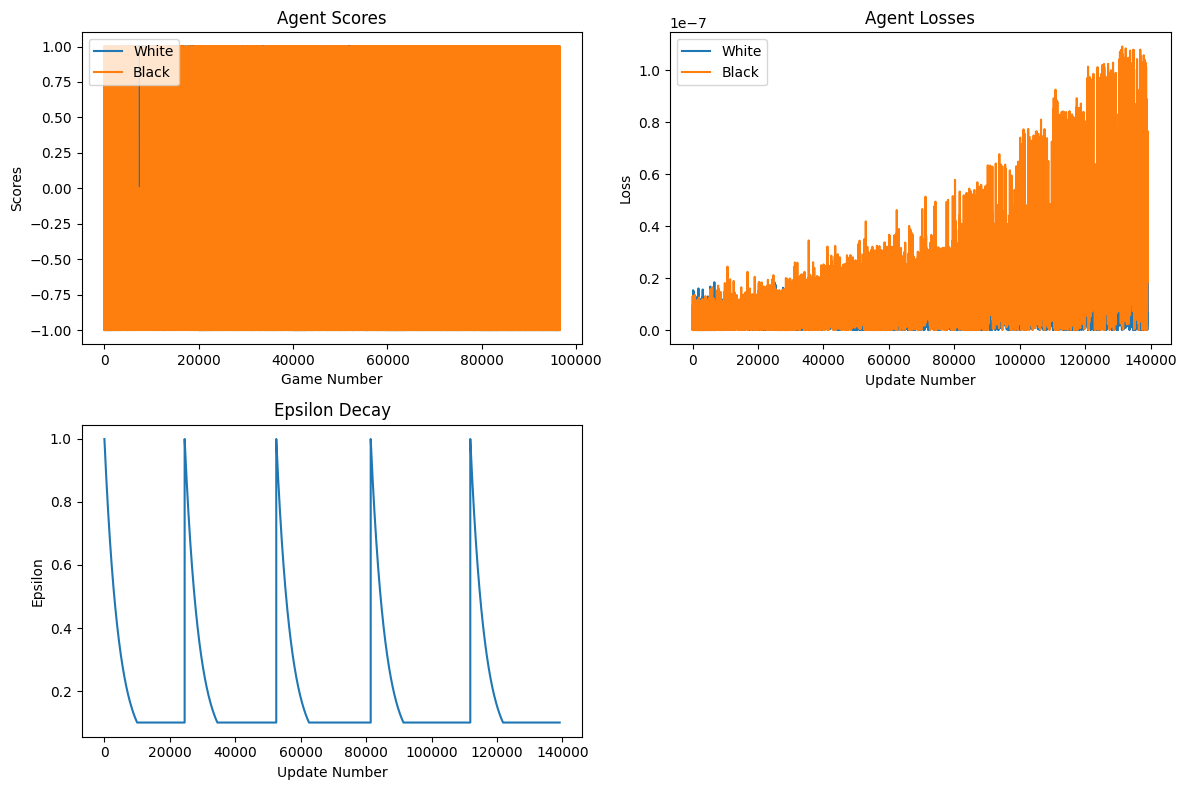

Game 96500 completed of 100000, 96.5% complete
Feature game move list (all moves chosen are ones the agents think are best in the position):
 1.g3 Nh6 2.a3 g6 3.h3 g5 4.c4 e6 5.c5 Bd6 6.c6 Qf6 7.e4 Qc3 8.b4 Qxc1 9.b5 Qc3 10.h4 Kd8 11.Bh3 Qc1 12.a4 Qc3 13.f3 Qc1 14.e5 Qc3 15.Qc2 gxh4 16.Bg4 h3 17.Bf5 Ke7 18.Nxc3 Nxf5 19.Ra3 dxc6 20.Ra1 c5 21.Ra3 c4 22.Rh2 Bd7 23.f4 Bc6 24.b6 cxb6 25.g4 b5 26.Qc1 b4 27.d3 bxa3 28.d4 a2 29.Nxh3 b6 30.a5 a1=Q 31.d5 Qxc1+ 32.Kf2 Qxc3 33.a6 Nxa6 34.Rh1 Qc1 35.Rh2 c3 36.Kf3 Nb4 37.Ke4 Qxf4+ 38.Nxf4 Be8 39.Nxe6 c2 40.Nd8 a5 41.Nc6+ Kf8 42.e6 b5 43.Ne5 Rb8 44.g5 f6 45.g6 Bxe5 46.g7+ Kg8 47.Rh1 Bf4 48.Rg1 Bg3 49.Rf1 Bd6 50.Rg1 Be5 51.Rf1 Bf4 52.Rc1 Nxd5 53.Rd1 b4 54.Re1 Bg3 55.Rd1 cxd1=Q 56.Kxf5 Qf3# 


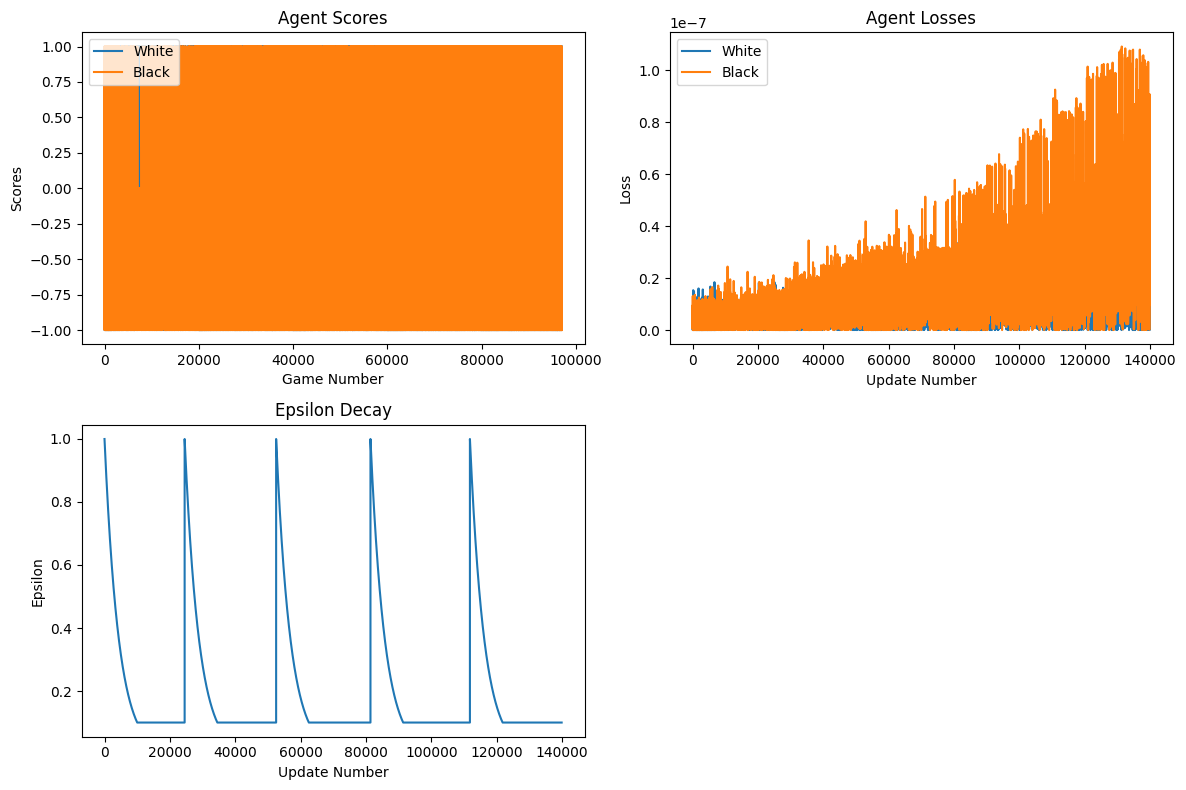

Game 97000 completed of 100000, 97.0% complete
Feature game move list (all moves chosen are ones the agents think are best in the position):
 1.g3 g6 2.a3 Nh6 3.e3 g5 4.h3 g4 5.hxg4 d6 6.g5 d5 7.g4 Be6 8.f3 f6 9.e4 dxe4 10.Bc4 Qd6 11.b3 Qxd2+ 12.Qxd2 Nc6 13.Qd8+ Nxd8 14.Nc3 Ndf7 15.Rh2 a6 16.Bb5+ c6 17.Rxh6 Bxg4 18.Nh3 Bxf3 19.Kf2 Bh1 20.b4 Ra7 21.Ra2 b6 22.Rb2 Rd7 23.Rb1 c5 24.Bxa6 cxb4 25.Rh4 bxa3 26.Ra1 a2 27.Rxa2 h6 28.Bb7 Rg8 29.Ra8+ Rd8 30.Bb2 h5 31.Ra2 Rg7 32.Bc1 Rg8 33.Ra3 f5 34.Ra6 b5 35.Ra4 b4 36.Ra7 e3+ 37.Ke1 Bxb7 38.Nd5 e2 39.c3 Bc6 40.Kf2 Rg7 41.Bb2 Rg8 42.g6 Rg7 43.Ra4 Rg8 44.Kg1 b3 45.Rag4 Bb7 46.Kh1 Rg7 47.Bc1 Rg8 48.g7 Rxg7 49.Bd2 Rg8 50.Rg6 Rg7 51.Rh6 Rb8 52.Nf4 Rg8 53.Be3 Rg7 54.c4 Rg8 55.Kh2 Rg7 56.Kh3 Rg8 57.Ne6 Rg7 58.Bg5 Rg8 59.Bf4 Rg7 60.Bc1 Rg8 61.Bd2 Rg7 62.Rh7 Rg8 63.Rh8 Rg7 64.R4xh5 Bc6 65.Rxf8+ Kd7 66.Rh6 Rg8 67.Kh4 Bb7 68.c5 Bc6 69.Bc1 Bb7 70.c6+ Kd6 71.Bb2 Rg7 72.Bc3 Rg8 73.Rh7 Kxd5 74.Rh8 Rg7 75.Kh5 Rg6 76.Bb4 Rg5+ 77.Nxg5 Ra8 78.Bc3 e6 79.Bd4 Ra3 80.Be

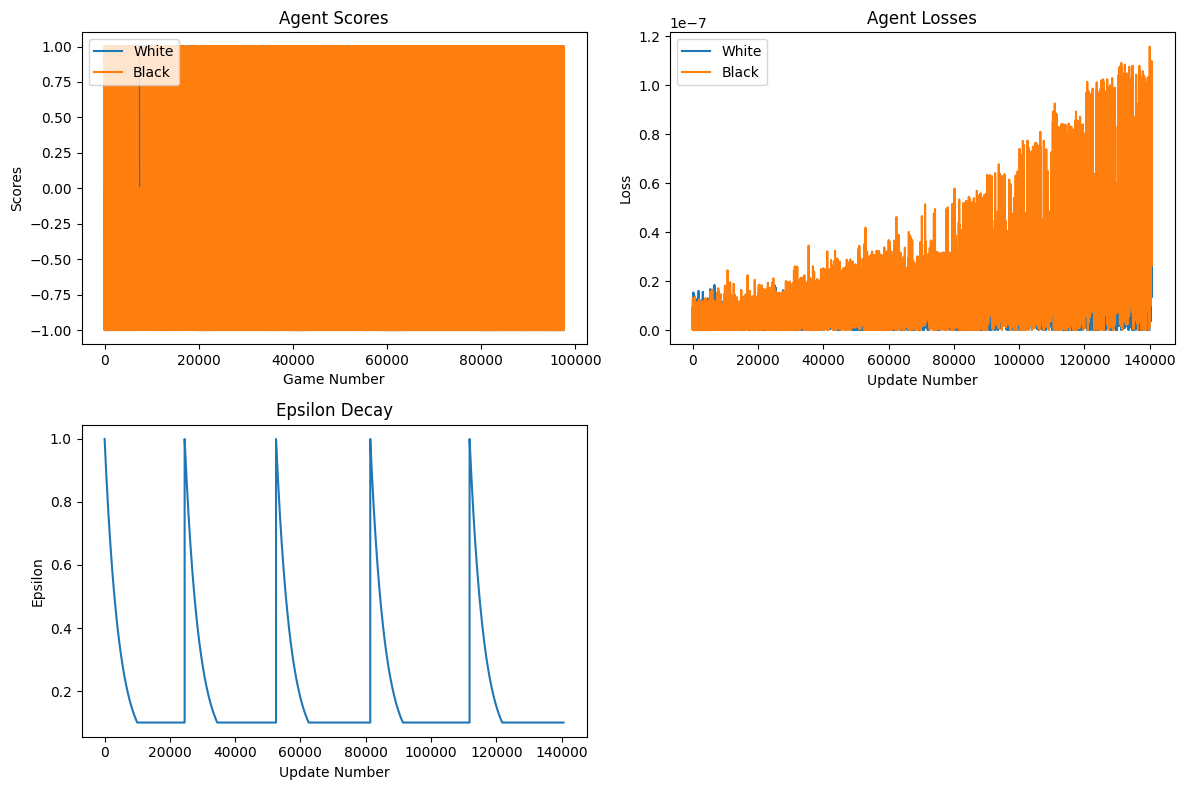

Game 97500 completed of 100000, 97.5% complete
Feature game move list (all moves chosen are ones the agents think are best in the position):
 1.g3 g6 2.a3 e6 3.Bg2 Qe7 4.d3 f6 5.Bd5 Bg7 6.h3 Nc6 7.e3 Nb4 8.c3 exd5 9.c4 Bf8 10.c5 g5 11.c6 Bg7 12.e4 dxe4 13.h4 Nd5 14.b4 Nxb4 15.f3 Nd5 16.Nc3 Qe6 17.Ra2 Qe5 18.Qa4 bxc6 19.Qxa7 Qf4 20.Qe3 Rxa3 21.Rb2 Rxc3 22.Kf2 Rxc1 23.g4 Rc3 24.Rb4 Rc1 25.Rh3 Rc3 26.Ke1 h6 27.Qd4 h5 28.fxe4 Rc1+ 29.Ke2 Rc3 30.Qxd5 Rc1 31.e5 Rc3 32.Kd1 Qxe5 33.Nf3 Bf8 34.gxh5 Rc1+ 35.Kd2 Be7 36.h6 Qe4 37.Qxe4 Rc3 38.d4 Rc1 39.d5 Rc3 40.Qxe7+ Kxe7 41.Nd4 f5 42.d6+ Kxd6 43.hxg5 Kd5 44.Rg3 Rc1 45.g6 c5 46.g7 c4 47.Kxc1 c3 48.Rg4 d6 49.Rg6 Bd7 50.Rxd6+ Kxd6 51.Rb5 Be6 52.Rb8 c2 53.Kb2 Kd5 54.Kb3 Nf6 55.g8=R Kd6+ 56.Kb4 Kd5 57.Rgf8 Ne8 58.Kc3 Kc5 59.Rfxe8 c6 60.h7 Bf7 61.Nf3 c1=Q+ 62.Kd3 f4 63.Nd4 Qc3+ 64.Ke4 Rg8 65.Ke5 Kc4 66.Kf6 Qc1 67.h8=Q Kc3 68.Qg7 Rh8 69.Qh7 f3 70.Qxh8 c5 71.Qg7 c4 72.Qh7 f2 73.Qh8 f1=B 74.Qg7 Bg6 75.Qh7 Qd1 76.Qh8 Qf3+ 77.Kg7 Qb7+ 78.Kf8 Qd5 79.Rb7 Qxd4

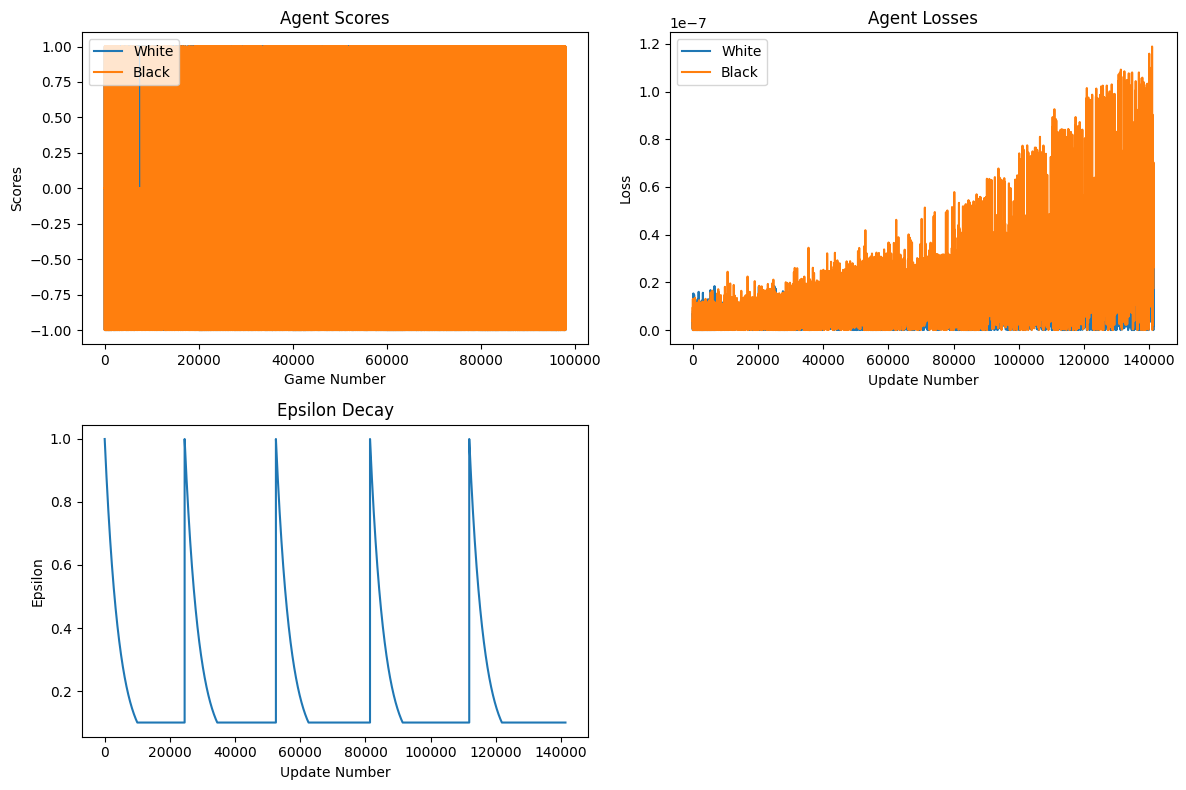

Game 98000 completed of 100000, 98.0% complete
Feature game move list (all moves chosen are ones the agents think are best in the position):
 1.g3 g6 2.a3 Nh6 3.e3 Bg7 4.Ke2 f6 5.Kd3 Rf8 6.c4 a5 7.c5 Rg8 8.c6 d6 9.Qf3 a4 10.Nc3 Bf8 11.Bg2 bxc6 12.Bh3 Bb7 13.Kc4 Ba6+ 14.Kd4 Ra7 15.Qe4 Rh8 16.Qe5 d5 17.d3 Bg7 18.Qe6 Bf8 19.g4 Qd6 20.Qf5 Qe6 21.Na2 Kd8 22.g5 Ke8 23.Bg4 gxf5 24.g6 f4 25.Bh5 f5 26.Nh3 Kd7 27.Rg1 Kd6 28.Rg3 Bg7# 


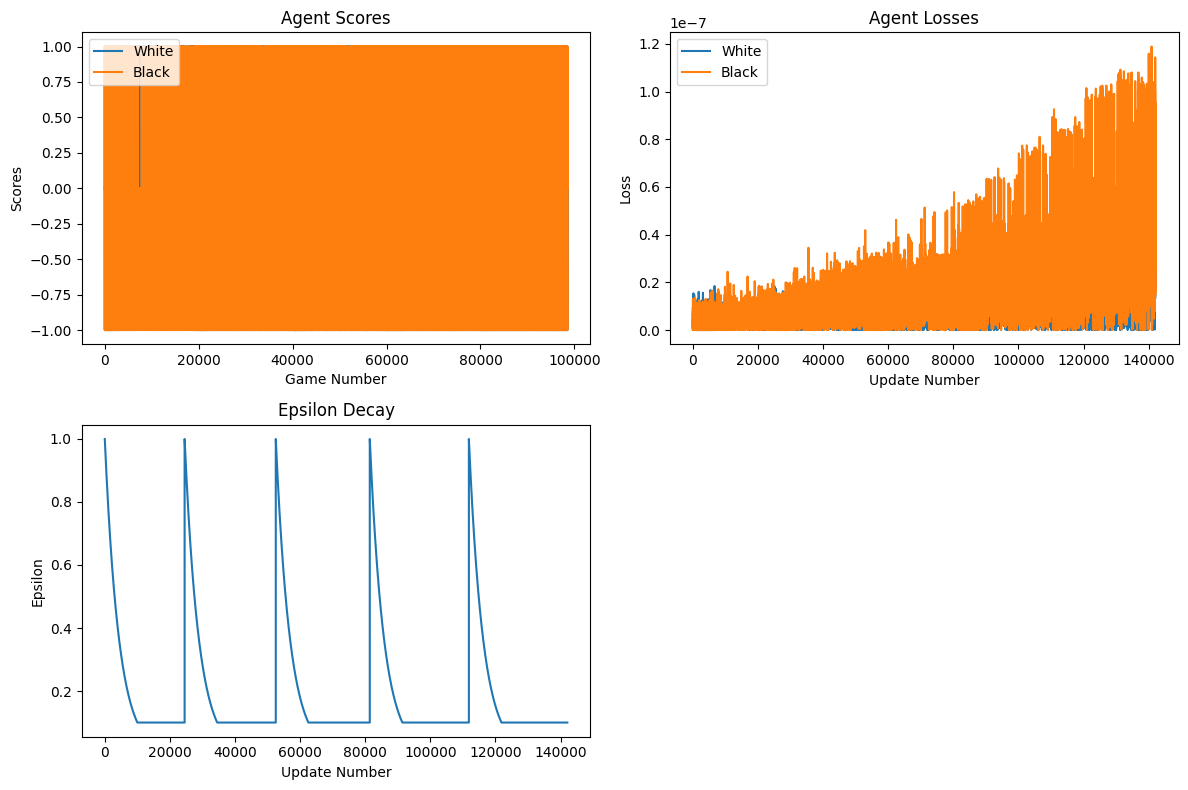

Game 98500 completed of 100000, 98.5% complete
Feature game move list (all moves chosen are ones the agents think are best in the position):
 1.f3 g6 2.g3 Bh6 3.a3 Bxd2+ 4.Nxd2 e6 5.Nb3 Qe7 6.e3 Qd6 7.h4 Qe7 8.Nd2 Qd6 9.Nb3 Qe7 10.a4 Qd6 11.Ke2 Qe7 12.Kd3 Qd6+ 13.Kc4 Qe7 14.Ra2 a5 15.Bh3 Qd6 16.Bg4 Qe7 17.Na1 Qd6 18.h5 Qe7 19.h6 Qd6 20.Qe1 Qe7 21.Qf1 Ra6 22.Qh3 Qd8 23.Kc5 Qe7+ 24.Kb5 Rb6+ 25.Kxa5 f5 26.c3 Qd6 27.e4 Qe7 28.e5 Qd6 29.c4 Qe7 30.c5 Qd6 31.c6 Qe7 32.Qh4 Qd6 33.Rh3 Qe7 34.Ra3 Qd6 35.Qh5 Qe7 36.Qg5 dxc6 37.Qf4 Qd6 38.Qd2 Qe7 39.Qd8+ Qxd8 40.Bh5 f4 41.g4 Bd7 42.Bd2 Kf8 43.Be3 Nxh6 44.Nb3 Qg5 45.Na1 Nxg4 46.Bxg4 h5 47.Nb3 Rb5+ 48.axb5 Kf7 49.Na1 h4 50.Ra4 Rg8 51.Nb3 c5 52.Na1 Bc6 53.b6 Rg7 54.b3 Kf8 55.b4 Rg8 56.Nb3 cxb4 57.Na1 cxb6+ 58.Bxb6 Rg7 59.Nb3 Rg8 60.Na1 Be4 61.Nb3 Ke7 62.Na1 Kf8 63.fxe4 Qf5 64.Nb3 Qxe5+ 65.Bc5+ Kf7 66.Rxh4 Qxe4 67.Bf8 Qd4 68.Na1 Qh8 69.Bh5 f3 70.Bg4 f2 71.Bh5 f1=R 72.Bg4 Rf2 73.Bh5 Rd2 74.Nb3 Rd7 75.Na1 Rxf8 76.Ra2 b3 77.Rb2 Re8 78.Nxb3 Qg8 79.Na1 Kf6

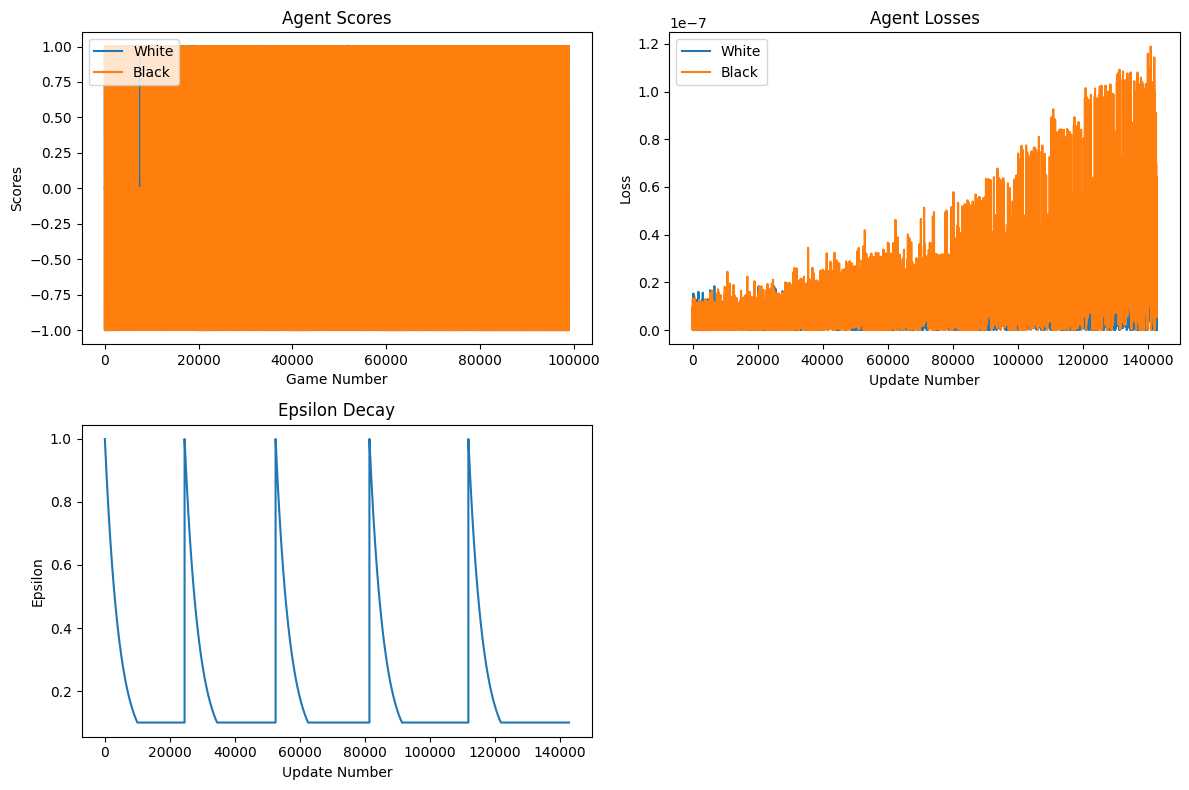

Game 99000 completed of 100000, 99.0% complete
Feature game move list (all moves chosen are ones the agents think are best in the position):
 1.g3 g6 2.a3 Nc6 3.e3 Nb4 4.Bg2 e6 5.Bd5 Be7 6.Qf3 Rb8 7.Ne2 Ra8 8.Nd4 Nh6 9.Qg4 Rf8 10.d3 Bd6 11.Qxg6 fxg6 12.Nd2 Rf7 13.N2b3 Be7 14.a4 Rg7 15.Ne2 Rg8 16.Ned4 e5 17.g4 g5 18.e4 Bd6 19.f3 Be7 20.h3 Bd6 21.h4 Bf8 22.h5 Be7 23.Ke2 Nxg4 24.h6 Nxh6 25.Kd1 g4 26.Ra3 gxf3 27.Na1 Kf8 28.Rh2 Qe8 29.Rxh6 d6 30.b3 Be6 31.Rh4 Bf7 32.Rh5 Qd8 33.Rh1 Qe8 34.Kd2 Rb8 35.Rh3 Bg6 36.c3 Ra8 37.Ke3 f2 38.Bb2 Bd8 39.Rh4 Ke7 40.Rh5 Qf8 41.Rh1 Bf5 42.c4 Bxe4 43.Rd1 Nxd5+ 44.Kxe4 h5 45.Rd2 Nf4 46.b4 Qf7 47.Bc3 d5+ 48.Kxe5 Ke8 49.b5 Qd7 50.Kxf4 Qe6 51.b6 Be7 52.Bb4 Bd6+ 53.Bxd6 Qe5+ 54.Kxe5 a6 55.Kf4 a5 56.Be5 Kf8 57.Ke3 Kf7 58.Bf4 c5 59.Be5 Kg6 60.Bf4 f1=B 61.Nc6 bxc6 62.d4 cxd4+ 63.Rxd4 c5 64.Nb3 h4 65.Na1 h3 66.Rc3 h2 67.Bd6 Kg5 68.Bb8 Ra7 69.Nb3 Rag7 70.Na1 Rb7 71.Nb3 Rxb6 72.Na1 Rb5 73.cxb5 Re8+ 74.Kd2 c4 75.Rf3 Re3 76.Kc1 Re8 77.Bd6 c3 78.Bb8 c2 79.Kb2 Rf8 80.b6 Rg

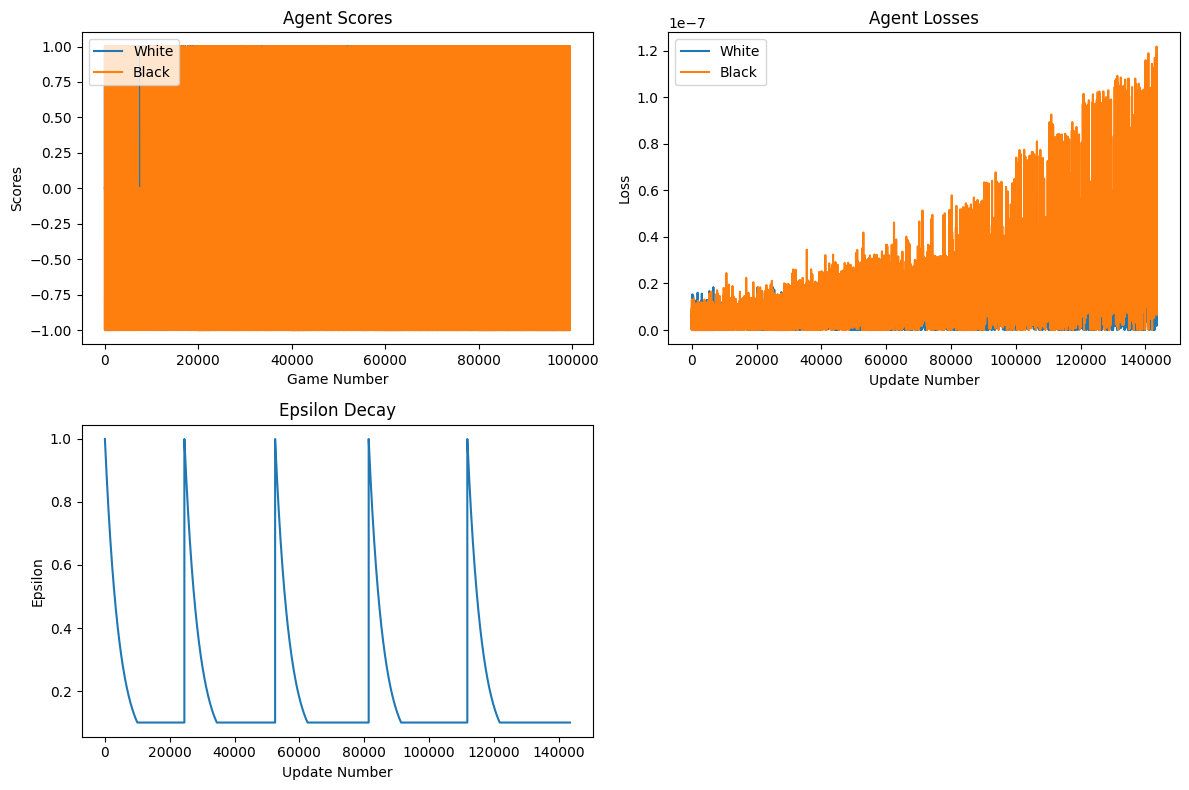

Game 99500 completed of 100000, 99.5% complete
Feature game move list (all moves chosen are ones the agents think are best in the position):
 1.g3 g6 2.e4 g5 3.a3 g4 4.Qe2 a5 5.Qd3 a4 6.e5 d5 7.Qc4 d4 8.Qe6 Qd6 9.Qf5 Qd5 10.Nf3 gxf3 11.Bb5+ Nc6 12.b4 Ra6 13.e6 Qe4+ 14.Kd1 Bxe6 15.Qh3 Bg4 16.Qxg4 b6 17.Qg6 fxg6 18.Bb2 Kd8 19.Bxa6 Nxb4 20.c3 b5 21.g4 h6 22.g5 h5 23.cxb4 Qe3 24.dxe3 e6 25.Nd2 Ke7 26.Ke1 h4 27.Kd1 h3 28.Ra2 Rh7 29.Nb3 Rh8 30.Na1 dxe3 31.Kc2 Bg7 32.Kd1 c5 33.Kc2 Kd6 34.Bxb5 e5 35.Kd1 Nf6 36.Bc3 Re8 37.Ba6 e4 38.b5 Bf8 39.b6 Kd5 40.Rb2 Kd6 41.Ke1 Be7 42.Rb4 Kd5 43.Rb5 Kd6 44.Kf1 Kd5 45.Rg1 Kc4 46.b7 Ng8 47.Rb6+ Kd5 48.Rg2 Bd8 49.Rg3 Be7 50.Bb4 cxb4 51.Rg4 bxa3 52.Kg1 a2 53.Kf1 Kd4 54.Rf4 a3 55.Rf5 e2+ 56.Kg1 Rf8 57.Rff6 Re8 58.Rbd6+ Ke5 59.Rc6 Bd8 60.Rf7 Be7 61.Nb3 Rf8 62.Na1 Bd8 63.Nb3 Be7 64.Na5 a1=Q+ 65.Rc1 Qxc1# 


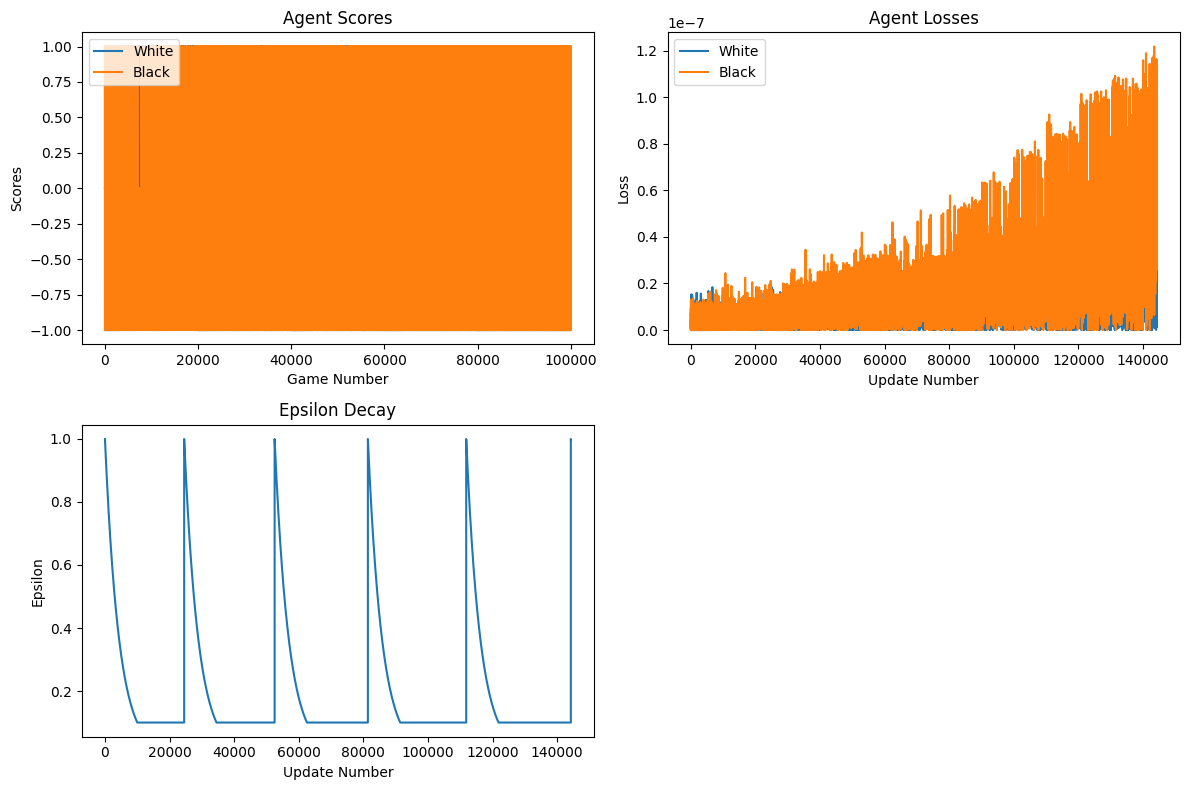

Game 100000 completed of 100000, 100.0% complete
Feature game move list (all moves chosen are ones the agents think are best in the position):
 1.c4 g5 2.Na3 Na6 3.Rb1 Nf6 4.d4 b5 5.Nxb5 c5 6.Nh3 Nh5 7.Qd3 e5 8.b3 f6 9.g4 Nb4 10.dxe5 Kf7 11.gxh5 Qe7 12.f3 h6 13.Ra1 Qe8 14.exf6 Bd6 15.Qd4 Na6 16.Qh4 Qf8 17.Nc3 Nc7 18.Nf2 g4 19.Bh3 Bb7 20.Bd2 Ke6 21.Qg5 Qe8 22.Nb5 Qxh5 23.Qxg4+ Qxg4 24.Bxh6 Rhg8 25.Bf1 a5 26.h3 Rgf8 27.Nd1 Bd5 28.Na7 Kxf6 29.cxd5 Qg7 30.Rc1 Rfe8 31.Rc4 Qh8 32.Ne3 Be5 33.Rg4 Rab8 34.a4 Ra8 35.Kf2 Qg7 36.Rg2 Bc3 37.Rg5 Re5 38.Ng4+ Ke7 39.d6+ Kd8 40.Nf6 Qg6 41.Nc8 Qh5 42.dxc7+ Kxc7 43.Rh2 Qg6 44.Bf8 Qb1 45.Kg3 Kb8 46.Kg2 Kxc8 47.Ne8 Rf5 48.Kg1 Be5 49.e4 Bf4 50.Kf2 Kb8 51.Bxc5 Qxf1+ 52.Kxf1 Rf7 53.b4 Be3 54.Nc7 Rf4 55.Ba7+ Kxa7 56.Rg1 Rf7 57.Rg7 Rf6 58.Na6 axb4 59.Re2 Raf8 60.Reg2 Rxa6 61.R7g5 Rd8 62.Rg1 Bb6 63.R5g4 d5 64.Rf4 Rc8 65.Rf8 Rc2 66.Rf6 Ka8 67.Rg7 Rd2 68.Rg4 Rxa4 69.Rgf4 Bd4 70.Ke1 Rh2 71.Rf8+ Kb7 72.R4f7+ Kc6 73.Ra8 dxe4 74.Kf1 Ra1+ 75.Rxa1 Ba7 76.Rf4 Bd4 77.Ra6+

In [32]:
def nth_root_of_point1(n):
    return 0.1**(1/n)

# Parameters
decay = nth_root_of_point1(10000)


chess_ai = MultiAgentDeepQ_Chess(
    buffer_size=100000,
    batch_size=64, 
    iters_between_network_copies=10000,
    epsilon_decay=decay,
    )

chess_ai.train(100000, 500)

In [33]:
import pickle

with open('DQN_chess_model_v1.pkl', 'wb') as f:
    pickle.dump(chess_ai, f, pickle.HIGHEST_PROTOCOL)